# PHYS202162 - Project 2 - Numerical Integration

Emily Gillott

March 2021

## Harmonic oscillator

In this project a variety of numerical methods will be used to analyse a mass sping system obaying $mx''(t) + bx' + kx = F(t)$ in order to select the best numberical method to describe the solution. Here "best" will be taken to mean the most accurate. First the free case will be analysed then the best method and time step for this system will be chosen. Then the best method will be used to analyse the forced cases.

## Free oscillations

First the four methods will be investigated on an unforced system to decide on the best method.

In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import find_peaks

# Set paramaters
k = 2.01 # kg / s**2
m = 3.05 # kg

# Set plotting paramaters
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

def free_analytic_solution(x0, v0, total_time, h_step):
    """
    Finds the analytic solution for free oscillations. 
    Returns two arrays, the position and the velocity as functions of time.
    """

    n_steps = int(total_time / h_step)
    time_range = np.linspace(0, total_time, n_steps)
    
    natural_frequency = cmath.sqrt(k / m)
    gamma = b / m
    frequency = cmath.sqrt(natural_frequency**2 - gamma**2 / 4)
    
    # If the system is critically damped (b = critical value)
    if (np.sqrt(4 * m * k) - 1e-8) < b < (np.sqrt(4 * m * k) + 1e-8):
        A = x0
        B = v0 + natural_frequency * A
        
        x_ana = (A + B * time_range) * np.exp(- natural_frequency * time_range)
        
        v_ana = (B * np.exp(-natural_frequency * time_range) 
                 - (A + B * time_range) * natural_frequency * np.exp(-natural_frequency * time_range))
        
    # If the system is under or over damped (b != critical value)
    else:
        # Find coefficients of the solution
        A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+1/2)*x0+v0*m/(cmath.sqrt(4*k*m-b**2)*1j)
        B = x0 - A
        
        x_ana = np.exp(-gamma * time_range / 2) * (A * np.exp(1j * frequency * time_range) 
                                                   + B * np.exp(-1j * frequency * time_range))
        v_ana = (-gamma / 2 * x_ana
                 + np.exp(-gamma * time_range / 2) * (A * 1j * frequency * np.exp(1j * frequency * time_range)
                                                     - B * 1j * frequency * np.exp(-1j * frequency *time_range)))
        
    
    return np.real(x_ana), np.real(v_ana)

def euler_method(x0, v0, total_time, h_step):
    """
    Uses Euler's method to find the solution for the free system. 
    Returns two arrays, the position and the velocity as functions of time.
    """
    n_steps = int(total_time / h_step)
    
    # Define arrays
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    
    # Assign inital conditions
    x[0] = x0
    v[0] = v0
    
    for i in range(n_steps - 1):
        
        # Find the acceleration at step i
        a = -(k / m) * x[i] - (b / m) * v[i]
        
        # Find the position and velocity at step i + 1 and add to the array
        x[i + 1] = x[i] + v[i] * h_step
        v[i + 1] = v[i] + a * h_step
        
    return x, v

def improved_euler_method(x0, v0, total_time, h_step):
    """
    Uses the improved Euler method to find the solution for the free system.
    Returns two arrays, the position and the velocity as functions of time.
    """
    n_steps = int(total_time / h_step)
    
    # Define arrays
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    
    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    
    for i in range(n_steps - 1):
        # Find the acceleration at step i
        a = -(k / m) * x[i] - (b / m) * v[i]
        
        # Find the position and velocity at step i + 1 and add to array
        x[i + 1] = x[i] + v[i] * h_step + (h_step**2 / 2) * a
        v[i + 1] = v[i] + a * h_step
        
    return x, v

def verlet_method(x0, v0, total_time, h_step):
    """
    Uses the Verlet method to find the solution for the free system. Note that the first step must use a different method
    (here the Euler method was used).
    Returns two arrays, the position and the velocity as a function of time.
    """
    n_steps = int(total_time / h_step)
    
    # Define arrays
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
     
    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    a = -(k / m) * x[0] - (b / m) * v[0]
    
    # Use Euler's method for the first step
    x[1] = x[0] + v[0] * h_step
    v[1] = v[0] + a * h_step
    
    # Define terms to be used in Verlet's method
    A = 2* (2 * m - k * h_step**2) / (2 * m + b * h_step)
    B = (b * h_step - 2 * m) / (2 * m + b * h_step)
    
    # Use Verlet's method to compute other steps
    for i in range(1, n_steps - 1):
        x[i + 1] = A * x[i] + B * x[i - 1]
        v[i] = (x[i + 1] - x[i - 1]) / (2 * h_step)
        
    # Compute the last velocity value
    x_temp = A * x[n_steps - 1] + B * x[n_steps - 2]
    v[n_steps - 1] = (x_temp - x[n_steps - 2]) / (2 * h_step)
        
    return x, v

def euler_cromer_method(x0, v0, total_time, h_step):
    """
    Uses the Euler-Cromer method to find the solution for a free system. 
    Returns two arrays, the position and the velocity as functions of time.
    """
    n_steps = int(total_time / h_step)
    
    # Define arrays
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    
    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    
    # Use the Euler-Cromer method to find the i + 1 step and add to the array
    for i in range(n_steps - 1):
        v[i + 1] = v[i] - ((h_step * k) / m) * x[i] - (h_step * b * v[i]) / m
        x[i + 1] = x[i] + h_step * v[i + 1]
        
    return x, v

### Undamped free system.
Firstly, the affect of the step size on the solution was investigated. 

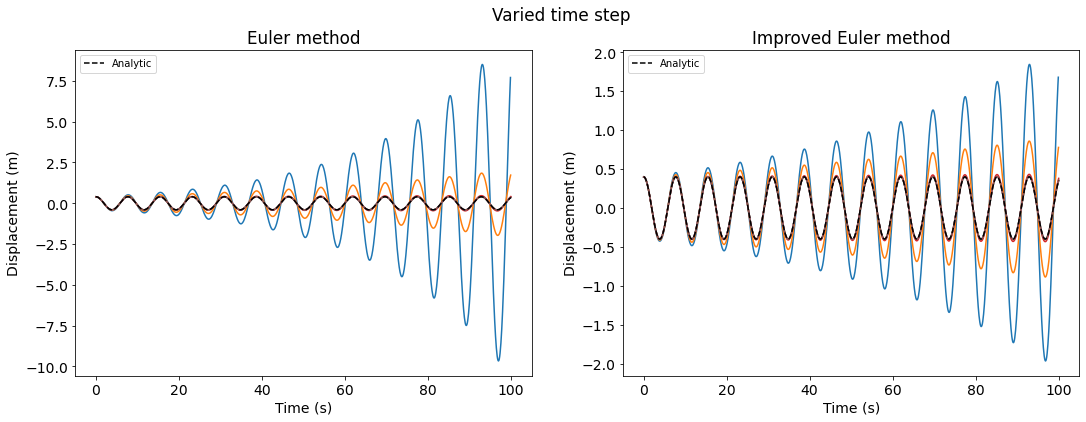

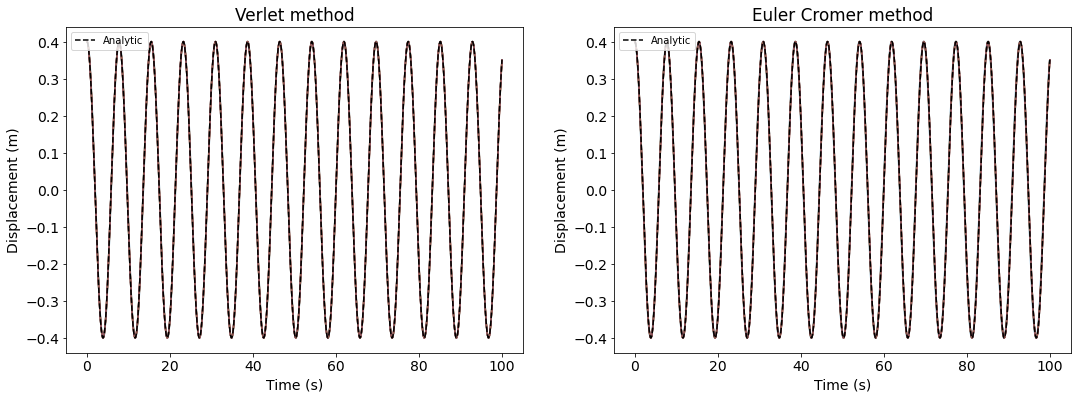

In [2]:
# Set damping coefficient
b = 0

# Set initial conditions
x0 = 0.4
v0 = 0

plt.rcParams['figure.figsize'] = (18, 6)

fig,(ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Varied time step')

fig,(ax3, ax4) = plt.subplots(1, 2)

time_steps0 = (0.1, 0.05, 0.001, 0.005, 0.0001, 0.0005) # s
total_time = 100 # s

for h_step in time_steps0:
        time_range = np.arange(0, total_time, h_step)
        
        # Call the methods
        euler_x = euler_method(x0, v0, total_time, h_step)[0]
        improved_euler_x = improved_euler_method(x0, v0, total_time, h_step)[0]
        verlet_x = verlet_method(x0, v0, total_time, h_step)[0]
        euler_cromer_x = euler_cromer_method(x0, v0, total_time, h_step)[0]
        
        # Plot the results
        ax1.plot(time_range, euler_x)
        ax2.plot(time_range, improved_euler_x)
        ax3.plot(time_range, verlet_x)
        ax4.plot(time_range, euler_cromer_x)
        
# Plot the analytical solution for each plot
analytic = free_analytic_solution(x0, v0, total_time, h_step)[0]
ax1.plot(time_range, analytic, 'k--', label='Analytic')
ax2.plot(time_range, analytic, 'k--', label='Analytic')
ax3.plot(time_range, analytic, 'k--', label='Analytic')
ax4.plot(time_range, analytic, 'k--', label='Analytic')

# Label axes
ax1.set(title='Euler method', xlabel='Time (s)', ylabel='Displacement (m)')
ax2.set(title='Improved Euler method', xlabel='Time (s)', ylabel='Displacement (m)')
ax3.set(title='Verlet method', xlabel='Time (s)', ylabel='Displacement (m)')
ax4.set(title='Euler Cromer method', xlabel='Time (s)', ylabel='Displacement (m)')

ax1.legend(fontsize=10, loc='upper left')
ax2.legend(fontsize=10, loc='upper left')
ax3.legend(fontsize=10, loc='upper left')
ax4.legend(fontsize=10, loc='upper left')
plt.show()
        

It can be seen for the Euler and improved Euler method that the numerical solution gets less acurate as the step size increases and the accuracy worstens as the number of steps increases (as time goes on).

To determine the best method, the methods will be compared for each step size.

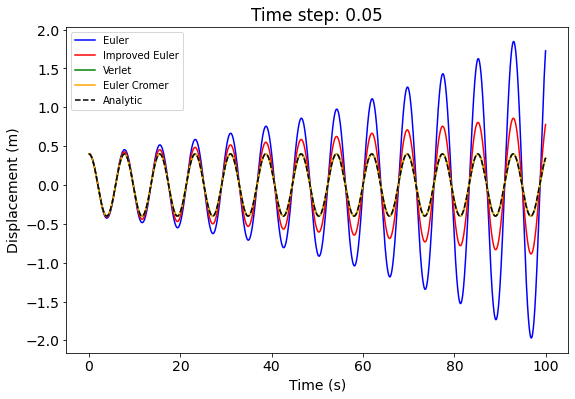

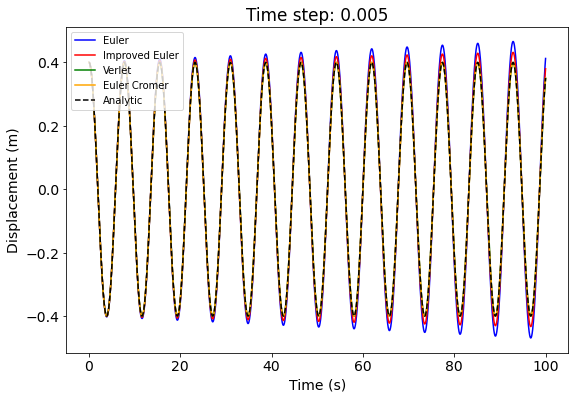

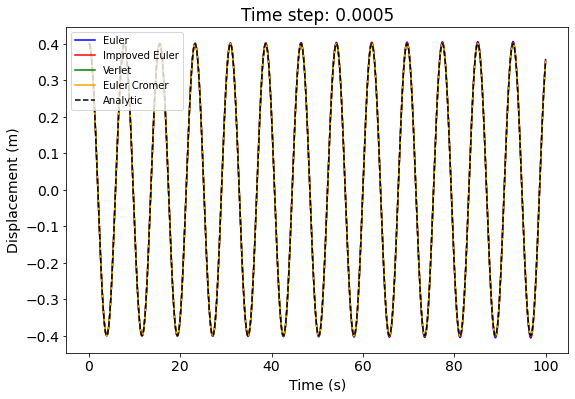

In [3]:
b = 0
time_steps = (0.05, 0.005, 0.0005) # s

plt.rcParams['figure.figsize'] = (9, 6)

def free_oscillations():
    """
    Compares each method for a given time step on a plot.
    """

    for i, h_step in enumerate(time_steps):
        figname = "fig" + str(i)
        figname = plt.figure()
    
        axname = "ax" + str(i)
        axname = figname.add_subplot(111)
    
        time_range = np.arange(0, total_time, h_step)
    
        # Call the methods
        eulerx = euler_method(x0, v0, total_time, h_step)[0]
        improved_eulerx = improved_euler_method(x0, v0, total_time, h_step)[0]
        verletx = verlet_method(x0, v0, total_time, h_step)[0]
        euler_cromerx = euler_cromer_method(x0, v0, total_time, h_step)[0]
        analytic = free_analytic_solution(x0, v0, total_time, h_step)[0]

        # Plot the results
        axname.plot(time_range, eulerx, label='Euler', color='blue')
        axname.plot(time_range, improved_eulerx, label='Improved Euler', color='red')
        axname.plot(time_range, verletx, label='Verlet', color='green')
        axname.plot(time_range, euler_cromerx, label='Euler Cromer', color='orange')
        axname.plot(time_range, analytic, 'k--', label='Analytic')
    
        string = 'Time step: {}'.format(h_step)
        plt.title(string)
        plt.xlabel('Time (s)')
        plt.ylabel('Displacement (m)')
        
        plt.legend(fontsize = 10, loc='upper left')

    plt.show()
    
free_oscillations()


Comparing all the methods, it is clear to see that the Euler method is the least accurate method to describe the system. Reducing the step size does drastically improve the accuracy though it remains the least accurate method for each step size. The Euler method has a local truncation error of the order of the time step, so over a large number of itterations the global truncation error will be large.

The improved euler method is more accurate than the Euler method. It has a local truncation error of the order of the time step cubed ($h_step^3$). But, over a large number of itterations the accuracy is worse than both the Verlet and Euler-Cromer methods.

Visually, the Verlet and Euler-Cromer methods are the more accurate than both the Euler and improved Euler methods though they cannot be distinguished on this scale. The Verlet method has a truncation error of the order of the time step ^4 which is a much higher accuracy then both the Euler and the improved Euler methods.  


### Investigating the energy

For undamped oscillations ($b=0$), energy is conserved. So a graph of energy against time is expected to be a horizontal line. For this system the energy is the sum of the kinetic and potential energies and is given by, $E(t) =1/2 k x^2 +\frac{1}{2}mv^2$. Using this expression the energy evolution of each numcerical method can be compared to the energy of th analytic solution.

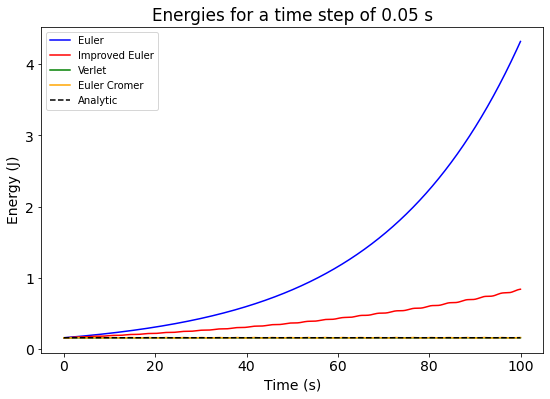

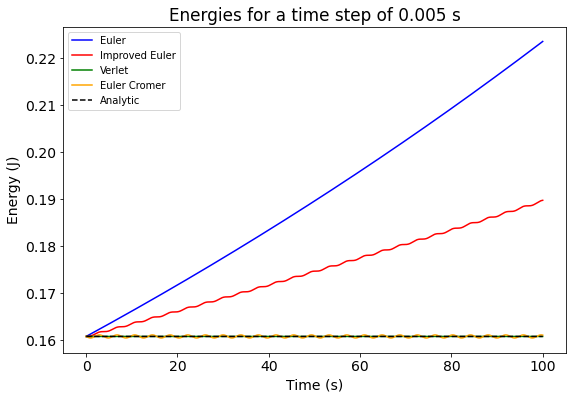

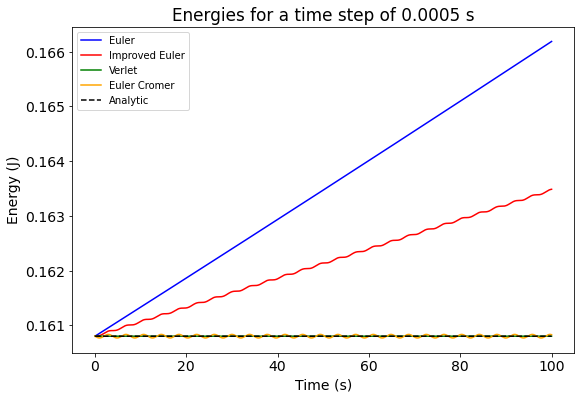

In [4]:
plt.rcParams['figure.figsize'] = (9, 6)

def energies(string):
    """
    Finds and plots the energy due to each method for a system.
    """
    # Set the range of time
    time_range = np.arange(0, total_time, h_step)
        
    # Call the methods
    (euler_x, euler_v) = euler_method(x0, v0, total_time, h_step)
    (improved_euler_x, improved_euler_v) = improved_euler_method(x0, v0, total_time, h_step)
    (verlet_x, verlet_v) = verlet_method(x0, v0, total_time, h_step)
    (euler_cromer_x, euler_cromer_v) = euler_cromer_method(x0, v0, total_time, h_step)
    
    # Calculate the energy for each method
    euler_E = 0.5 * k * euler_x**2 + 0.5 * m * euler_v**2
    improved_euler_E = 0.5 * k * improved_euler_x**2 + 0.5 * m * improved_euler_v**2
    verlet_E = 0.5 * k * verlet_x**2 + 0.5 * m * verlet_v**2
    euler_cromer_E = 0.5 * k * euler_cromer_x**2 + 0.5 * m * euler_cromer_v**2
    
    # Set paramaters for the analytic solution
    gamma = b / m
    natural_frequency = cmath.sqrt(k / m)
    frequency = cmath.sqrt(natural_frequency**2 - gamma**2 / 4)
  
    
    # Find the energy from the analytic solution
    analytic_E = ((x0**2 * np.exp(-gamma * time_range / 2)) / (8 * m) 
                  * (4 * k * m + b**2 * np.cos(2* frequency * time_range) + 2 * m * b * frequency 
                     * np.sin(2 * frequency * time_range)))
    
    analytic_E = np.real(analytic_E)
    
    # Plot the energies
    plt.plot(time_range, euler_E, label='Euler', color='blue')
    plt.plot(time_range, improved_euler_E, label='Improved Euler', color='red')
    plt.plot(time_range, verlet_E, label='Verlet', color='green')
    plt.plot(time_range, euler_cromer_E, label='Euler Cromer', color='orange')
    plt.plot(time_range, analytic_E, 'k--', label='Analytic')
    plt.title(string)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')
    plt.legend(fontsize=10, loc = 'upper left')
    plt.show()
    
    
for i, h_step in enumerate(time_steps):
    string = 'Energies for a time step of {} s'.format(h_step)
    energies(string)
    

From these graphs, it is clear to see that the Euler and improved Euler methods so not conserve energy for any of the time steps. Therefore, these methods will be discarded as they do not well represent the analytical solution at any time step. Now the choice for the most suitable method is between the Verlet and the Euler-Cromer methods. The energy graphs were replotted with only the Verlet and Euler-Cromer energies to properly analyse them.

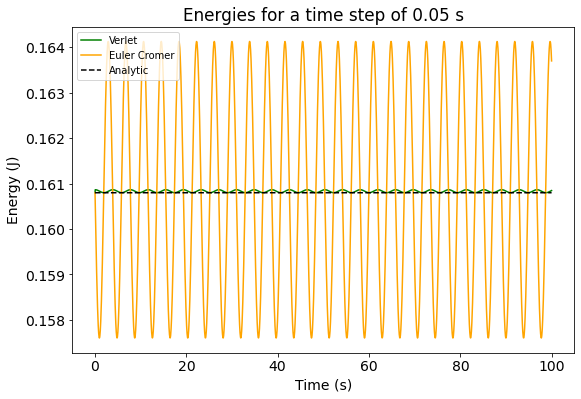

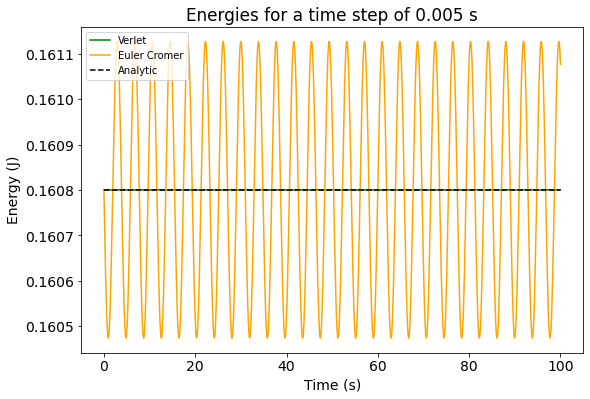

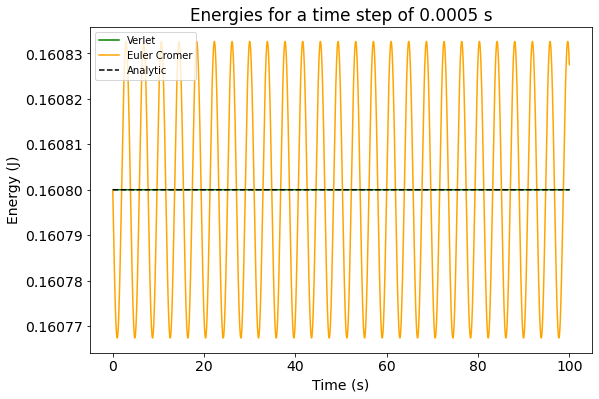

In [5]:
plt.rcParams['figure.figsize'] = (9, 6)

def energies2(string):
    """
    Plots the energy for the Verlet and Euler- Cromer methods
    """
    # Set the range of time
    time_range = np.arange(0, total_time, h_step)
        
    # Call the methods
    (verlet_x, verlet_v) = verlet_method(x0, v0, total_time, h_step)
    (euler_cromer_x, euler_cromer_v) = euler_cromer_method(x0, v0, total_time, h_step)
    
    # Calculate the energy for each method
    verlet_E = 0.5 * k * verlet_x**2 + 0.5 * m * verlet_v**2
    euler_cromer_E = 0.5 * k * euler_cromer_x**2 + 0.5 * m * euler_cromer_v**2
    
    # Set paramaters for the analytic solution
    gamma = b / m
    natural_frequency = cmath.sqrt(k / m)
    frequency = cmath.sqrt(natural_frequency**2 - gamma**2 / 4)
  
    
    # Find the energy from the analytic solution
    (ana_x, ana_v) = free_analytic_solution(x0, v0, total_time, h_step)
    
    analytic_E = 0.5 * k * ana_x**2 + 0.5 * m * ana_v**2
    
    # Plot the energies
    plt.plot(time_range, verlet_E, label='Verlet', color='green')
    plt.plot(time_range, euler_cromer_E, label='Euler Cromer', color='orange')
    plt.plot(time_range, analytic_E, 'k--', label='Analytic')
    plt.title(string)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')
    plt.legend(fontsize=10, loc='upper left')
    
    
    
for i, h_step in enumerate(time_steps):
    string = 'Energies for a time step of {} s'.format(h_step)
    energies2(string)
    plt.show()

On average, both methods conserve energy but also oscillate about the energy. However the Euler-Cromer oscillates with a much greater amplitude suggesting that the method is less accurate in considering both the displacement and the velocity.

Decreasing the time step reduces the amplitude of oscillation for the Verlet method as the oscillations are no longer visible but the amplitude for the Euler-Cromer method does not change significantly suggesting that the source of the error is not due to the time step but due to the method.

### Residuals
As on the previous plots the accuracy of the methods was not visible, the residuals and the average accuracy per step was investigated. The average accuracy per step was found by summing the modulus of the differences and dividing by the number of steps taken.

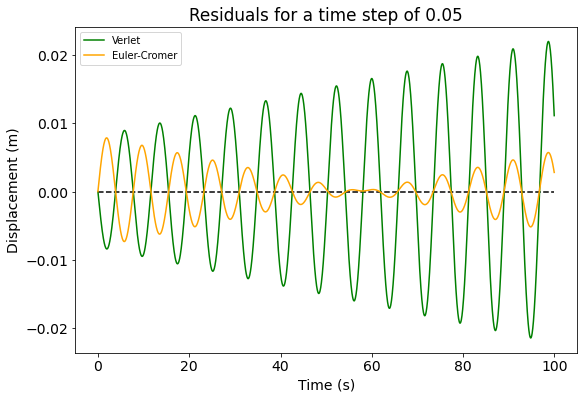

Verlet accuracy per step: 9.6801 e -3.0
Euler-Cromer accuracy per step: 2.3021 e -3.0


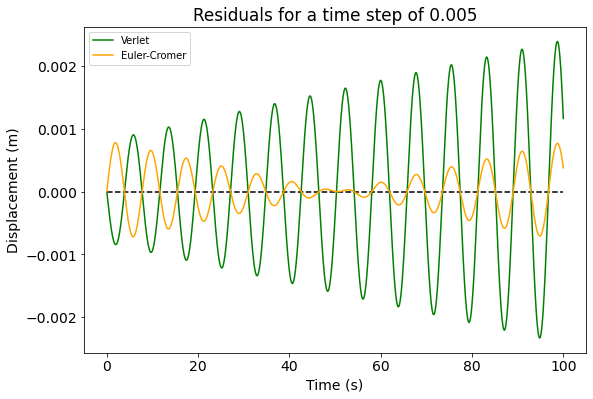

Verlet accuracy per step: 1.0324 e -3.0
Euler-Cromer accuracy per step: 2.5682 e -4.0


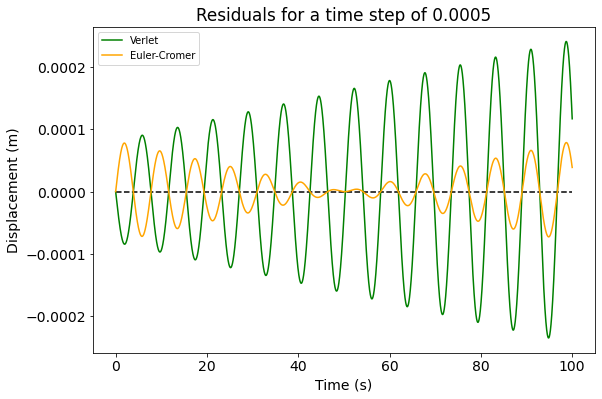

Verlet accuracy per step: 1.0388 e -4.0
Euler-Cromer accuracy per step: 2.6002 e -5.0


In [6]:
def standard_form(value, decimals=4):
    """
    Converts a value into standard form.
    Returns the stem of the value and the power of ten.
    """
    
    value = np.abs(value)
    
    power_of_ten = np.floor(np.log10(value))    
    stem = np.round(value / (10 ** power_of_ten), decimals=decimals)
    
    return stem, power_of_ten

def residuals(analytic_solution, numerical_solution):
    """
    Returns an array of the residuals between an analytic solution and a numerical solution.
    """
    residuals = numerical_solution - analytic_solution
    
    return residuals

def residuals_position(string):
    """
    Plots the residuals of the plot and finds the averange error per step for each time step.
    """
    time_range = np.arange(0, total_time, h_step)
    n_steps = int(total_time / h_step)
    
    # Call the methods
    verlet_x = verlet_method(x0, v0, total_time, h_step)[0]
    euler_cromer_x = euler_cromer_method(x0, v0, total_time, h_step)[0]
    analytic = free_analytic_solution(x0, v0, total_time, h_step)[0]
    
    # Find the residuals
    verlet_residuals = residuals(verlet_x, analytic)
    euler_cromer_residuals = residuals(euler_cromer_x, analytic)
    
    # Plot the solution
    plt.plot(time_range, verlet_residuals, color='green', label='Verlet')
    plt.plot(time_range, euler_cromer_residuals, color='orange', label='Euler-Cromer')
    plt.hlines([0], 0, total_time, color='black', linestyle='--')
    
    title = string #'Residuals for a time step of {}'.format(h_step)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    
    plt.legend(fontsize=10)
    plt.show()
    
    # Find the average error per step
    verlet_accuracy = np.sum(np.abs(verlet_residuals)) / n_steps
    euler_cromer_accuracy = np.sum(np.abs(euler_cromer_residuals)) / n_steps
    
    print('Verlet accuracy per step: {} e {}'.format(standard_form(verlet_accuracy)[0], standard_form(verlet_accuracy)[1]))
    print('Euler-Cromer accuracy per step: {} e {}'.format(standard_form(euler_cromer_accuracy)[0],
                                                      standard_form(euler_cromer_accuracy)[1]))
    
for h_step in time_steps:
    string = 'Residuals for a time step of {}'.format(h_step)
    residuals_position(string)

From the plots and average accuracy per step the Euler-Cromer method is the most accurate for all the time steps.

## Damped system

So far, only undamped oscillations have been considered. The Verlet and Euler-Cromer methods were investigated for a range of damping coefficients (b) before deciding on the best method to describe the system.

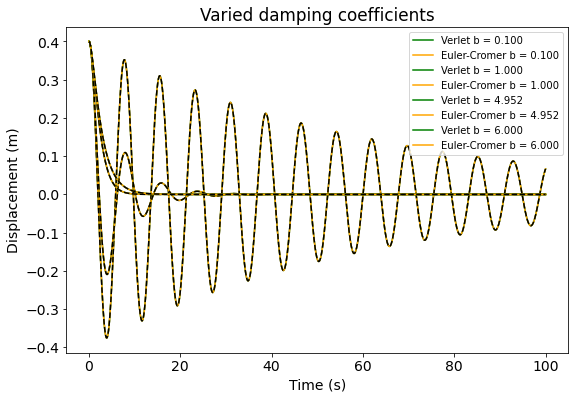

In [7]:
# Set a range of b values
damping_coeffs = (0.1, 1, np.sqrt(4 * k * m), 6)

def free_oscillations2():
    """
    """
    
    time_range = np.arange(0, total_time, h_step)
    
    # Call the methods
    
    verletx = verlet_method(x0, v0, total_time, h_step)[0]
    euler_cromerx = euler_cromer_method(x0, v0, total_time, h_step)[0]
    analytic = free_analytic_solution(x0, v0, total_time, h_step)[0]

    # Plot the results
    verlet_string = 'Verlet b = {0:.3f}'.format(b)
    euler_cromer_string = 'Euler-Cromer b = {0:.3f}'.format(b)
    plt.plot(time_range, verletx, color='green', label=verlet_string)
    plt.plot(time_range, euler_cromerx, color='orange', label=euler_cromer_string)
    plt.plot(time_range, analytic, 'k--')
    
    plt.title('Varied damping coefficients')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.legend(fontsize=10, loc = 'upper right')

    
for b in damping_coeffs:
    free_oscillations2()

plt.show()

The plot shows that both solutions are well behaved for a variety of damping coefficients. 

### Energy
Now condider the energy for the damped case.

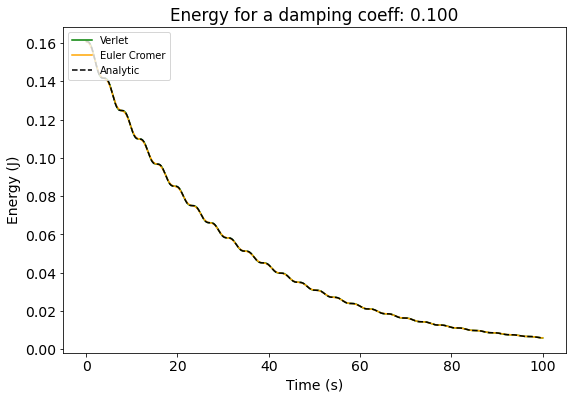

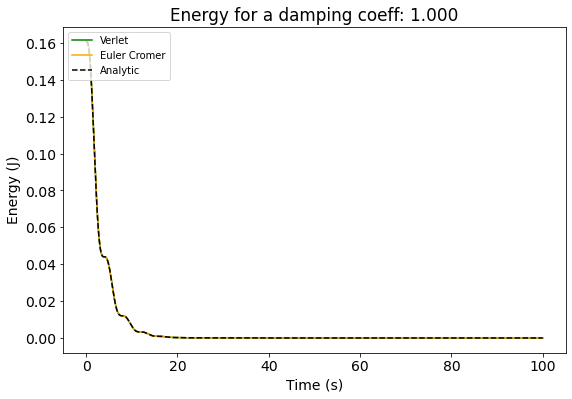

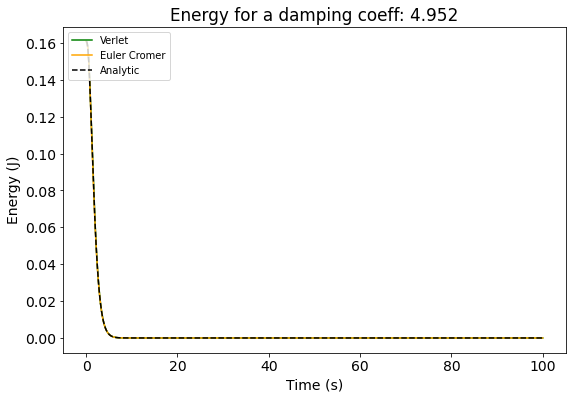

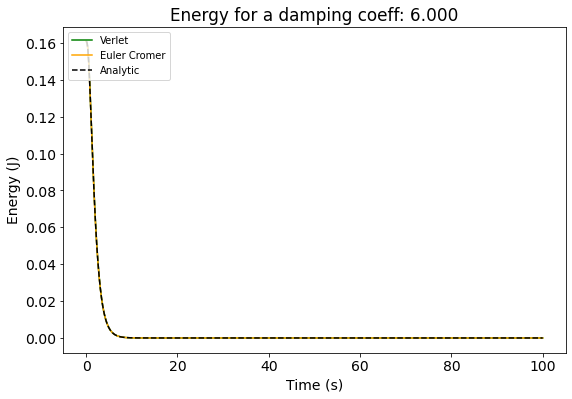

In [8]:
h_step = 0.01

for b in damping_coeffs:
    string = 'Energy for a damping coeff: {0:.3f}'.format(b)
    energies2(string)
    plt.show()

In a damped system energy is lost so the energy is excpected to decay to zero at different rates depending on the value of the damping coefficient. Here it can be seen that both numerical solutions well describe the energy. For an underdamped system (the coefficient is less than the critical value) the energy should decay slowy towards zeros as the oscillations do. For critically and overdamped systems the energy decays to zero quickly without oscillation.

Now investigate the residuals and average error per step for the damped case.

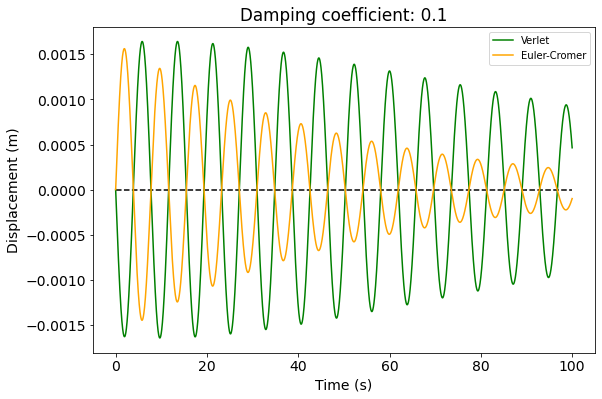

Verlet accuracy per step: 8.7542 e -4.0
Euler-Cromer accuracy per step: 4.5118 e -4.0


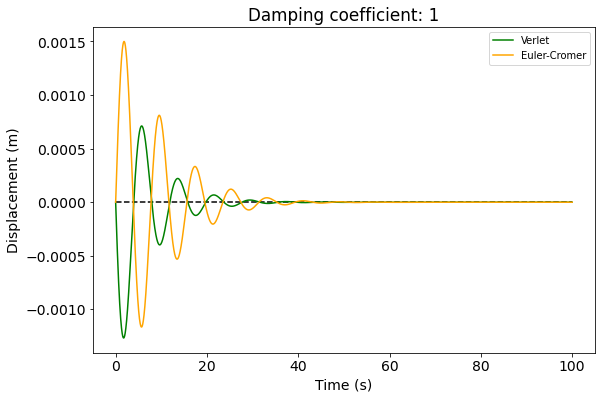

Verlet accuracy per step: 7.1582 e -5.0
Euler-Cromer accuracy per step: 1.1921 e -4.0


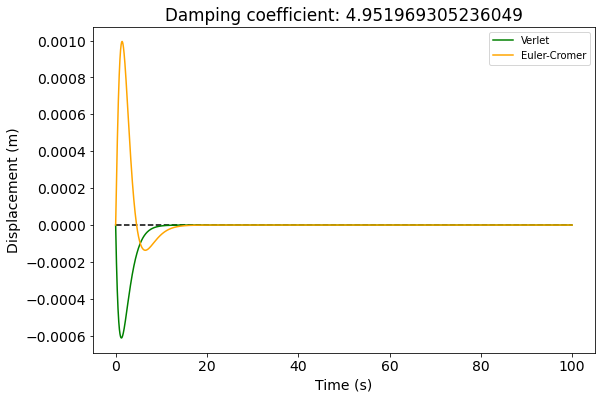

Verlet accuracy per step: 2.0985 e -5.0
Euler-Cromer accuracy per step: 3.1609 e -5.0


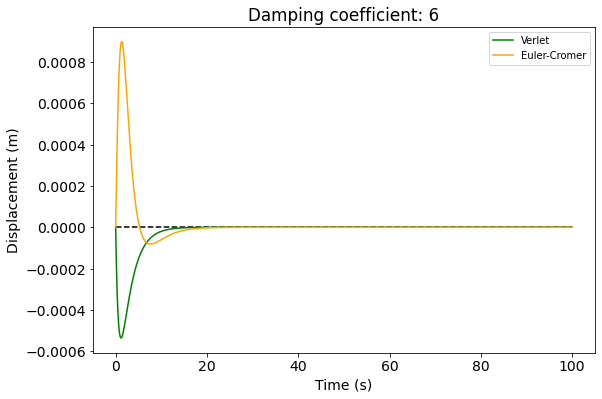

Verlet accuracy per step: 2.1194 e -5.0
Euler-Cromer accuracy per step: 2.9227 e -5.0


In [9]:
for b in damping_coeffs:
    string = 'Damping coefficient: {}'.format(b)
    residuals_position(string)

From both the residual plots and the average error per step, the Verlet method appears to be the more accurate method for a general value of b. The Euler-Cromer method is the most accurate for very small b. Therefore, the Verlet method is going to be considered the best numerical solution to describe this system.

### Choose a step size

To choose a suitable step size a tolerance is chosen and the average error per step and the error of the second to last peak is investigated. The second to last peak was chosen over the last peak because the last local maximum may not be an actual maximum of the position but the oscillation being cut off at the end of the investigated time range.

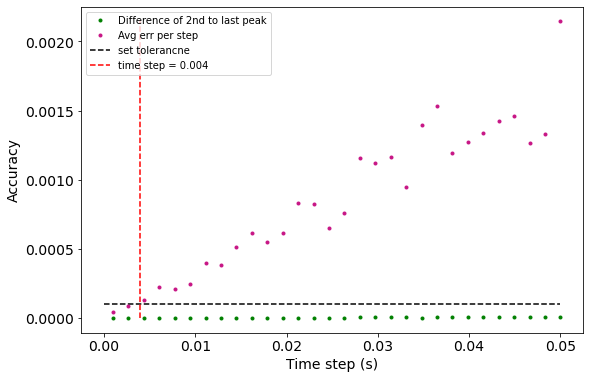

In [10]:
# Set a tolerance
b = 0.2
set_tolerance = 0.0001 # Tolerance of 0.1mm
h_step_range = np.linspace(0.001, 0.05, 30) # cannot have a time step of 0 so choose a very small number to start

def tolerance():
    """
    Finds the best step size for a given tolerance
    """
    
    x_verlet = verlet_method(x0, v0, total_time, h_step)[0]
    v_local_max = find_peaks(x_verlet, height=0)[0]
    
    x_analytic = free_analytic_solution(x0, v0, total_time, h_step)[0]
    ana_local_max = find_peaks(x_analytic)[0]
    
    error = x_verlet[v_local_max[-2]] - x_analytic[ana_local_max[-2]]
    
    
    return np.abs(error)

errors = np.empty(len(h_step_range))
avg_residuals = np.empty(len(h_step_range))

for i, h_step in enumerate(h_step_range):
    
    n_steps = int(total_time / h_step)
    
    # The tolerance
    error = tolerance()
    errors[i] = error
    
    # The sum of the residuals
    avg_residuals[i] = np.sum(np.abs(residuals(euler_cromer_method(x0, v0, total_time, h_step)[0], 
                                     free_analytic_solution(x0, v0, total_time, h_step)[0]))) / n_steps
    
    
plt.hlines([set_tolerance,], 0, np.max(h_step_range), color='k', linestyle='--', label='set tolerancne')
plt.vlines([0.004], 0, np.max(avg_residuals), color='red', linestyle='--', label='time step = 0.004')
    
plt.plot(h_step_range, errors, '.', label='Difference of 2nd to last peak', color='green')
plt.plot(h_step_range, avg_residuals, '.', label='Avg err per step', color='mediumvioletred')
plt.xlabel('Time step (s)')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.show()
    

For a tolerance of 0.1 mm a time step of 0.004 s is sufficiently small. For all the considered time steps the accuracy of the last peak is higher than the tolerance so the parameter dictating the time step is the average error per step.

# Investigate the system

As the best method and step size have been identified, the Verlet method will be used to investigate the system.

### Damping

Now investigate how the Verlet method describes the system for a damping coefficienct at half the critical value, the critical value and twice the critical value, where the critical value is given by $b = \frac{1}{2} \sqrt{4mk}$.

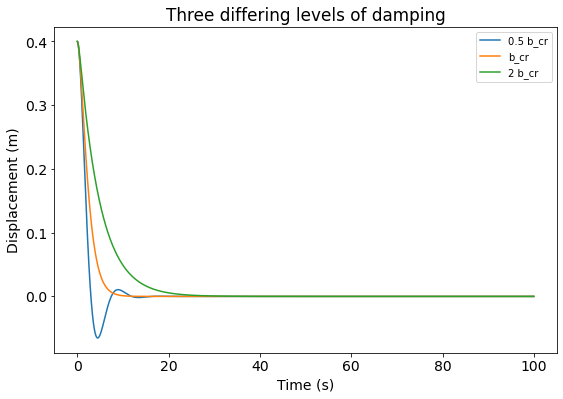

In [11]:
#Fix the ideal time step
h_step = 0.004 # s

# Set damping coefficients
b_critical = np.sqrt(4 * k * m)
B = (0.5 * b_critical, b_critical, 2 * b_critical)

time_range = np.arange(0, total_time, h_step)

for i, b in enumerate(B):

    x, v = verlet_method(x0, v0, total_time, h_step)
    
    strings = ('0.5 b_cr', 'b_cr', '2 b_cr')
    plt.plot(time_range, x, label= strings[i])
    
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Three differing levels of damping')

plt.legend(fontsize=10)
plt.show()


At half the critical value the system is underdamped. This can be seen as the system still oscillates as it dips below 0 displacement and back up again before returning to zero.

At the critical value the system is critically damped. There are no oscillations and the displacement goes to 0 in the least time.

At twice the critical value the system is overdamped. There are no oscillations and the displacement decays to zero but slower than the critically damped case.

The numerical solution agrees with the expected behaviour.


## Forced Oscillations

In [12]:
def delta_force(F0, push_time):
    """
    Force in the form of a delts function, a 'push' at time t.
    """
    n_steps = int(total_time / h_step)
    push_index = int(push_time / h_step)
    
    force = np.zeros(n_steps)
    
    force[push_index] = F0
    
    return force

def periodic_force(frequency, total_time, h_step, phase, F0):
    """
    A sinusoidal force. 
    """
    n_steps = int(total_time / h_step)
    
    time = np.linspace(0, total_time, n_steps)
    
    force = F0 * np.sin(frequency * time + phase)
    
    return force

def forced_analytical_solution(x0, v0, total_time, h_step, force):
    """
    Finds the analytical solution for a forced system by adding the solution of a free system to the solution of the force.
    """
    # Make an array for the time
    time_range = np.arange(0, total_time, h_step)
    
    # Define constants used in the forced part of the solution
    f0 = np.max(force)
    gamma = b / m
    natural_frequency = k / m
    frequency = cmath.sqrt(natural_frequency**2 - gamma**2 / 4)
    amplitude = (f0 / m) / cmath.sqrt((natural_frequency**2 - frequency**2)**2 + frequency**2 * gamma**2)
    phase = np.arctan((gamma * frequency) / (natural_frequency**2 - frequency**2))
    
    x_forced = amplitude * np.exp(1j * (frequency * time_range - phase))
    
    # If the system is critically damped
    if (np.sqrt(4 * m * k) - 1e-8) < b < (np.sqrt(4 * m * k) + 1e-8):
        A = x0
        B = v0 + natural_frequency * A
        
        x_ana = (A + B * time_range) * np.exp(- natural_frequency * time_range)
        
    # If the system is under or over damped
    else:
        # Find coefficients of the solution
        B = (- gamma / 2 * (x0 + amplitude) + 1j * frequency * x0) / (gamma + 2 * 1j * frequency)
        
        x_ana = np.exp(-gamma / 2 * time_range) * (A * np.exp(1j * frequency * time_range) 
                                                   + B * np.exp(-1j * frequency * time_range))
    
    # The solution is the sum of the free case and the forced
    x = x_free + x_forced
    
    return x

def forced_verlet_method(x0, v0, total_time, h_step, force):
    """
    Solves the differential equation using Verlet's method. Note that the fist step must be done using a different method.
    """
    n_steps = int(total_time / h_step)
    
    # Define arrays
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
     
    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    a = -(k / m) * x[0] - (b / m) * v[0] + force[0] / m
    
    # Use Euler's method for the first step
    x[1] = x[0] + v[0] * h_step
    v[1] = v[0] + a * h_step
    
    # Define terms to be used in Verlet's method
    D = b * h_step + 2 * m
    A = 2 * (2 * m - k * h_step**2)
    B = b * h_step - 2 * m
    
    # Use Verlet's method to compute other steps
    for i in range(1, n_steps - 1):
        
        x[i + 1] = A * x[i] / D + B * x[i - 1] / D + 2 * h_step**2 * force[i] / D 
        
    return x

### 'Push' force

The system was investigated when a 'pushed'. The force is modeled as a delta function (zero at all times apart from one instant).

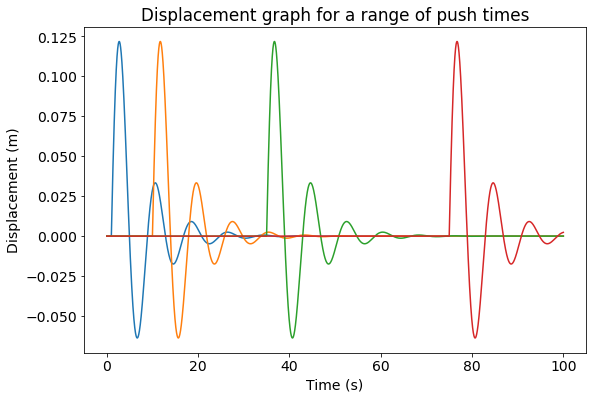

In [13]:
F0 = 100 # N
b = 1
push_times = (1, 10, 35, 75) # s
n_steps = int(total_time / h_step)

# Set new initial conditions
x0 = 0
v0 = 0

for push_time in push_times:
    
    force = delta_force(F0, push_time)
    time_range = np.linspace(0, total_time, n_steps)
    displacement = forced_verlet_method(x0, v0, total_time, h_step, force)
    
    plt.plot(time_range, displacement)

plt.title('Displacement graph for a range of push times')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.show() 

When the system starts at rest pushing the system starts oscillations which then decay normally due to damping.

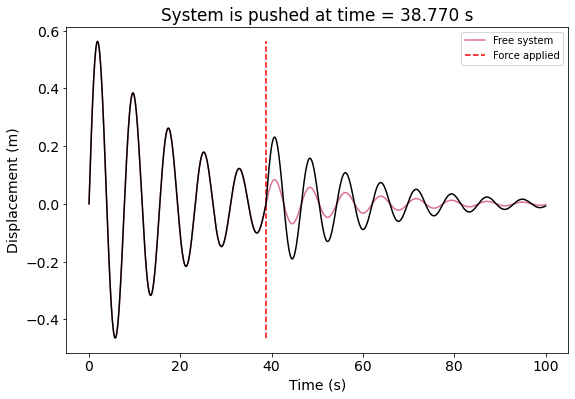

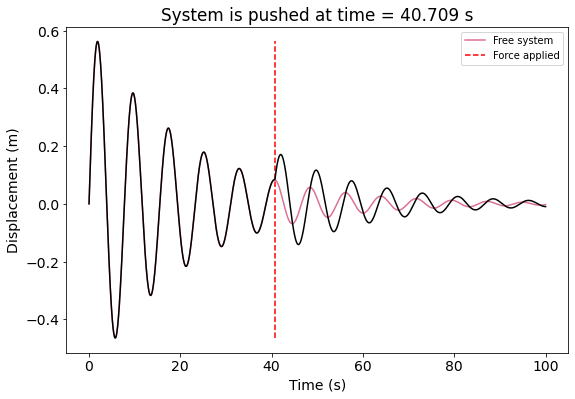

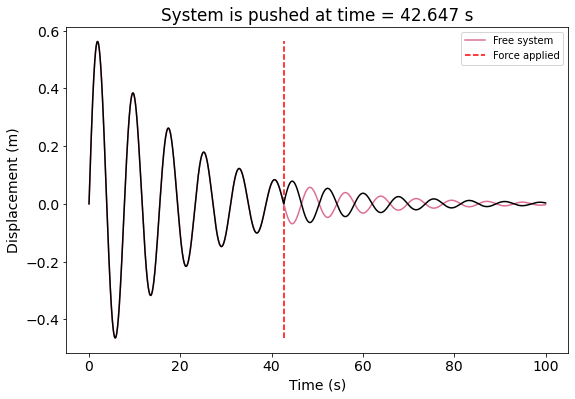

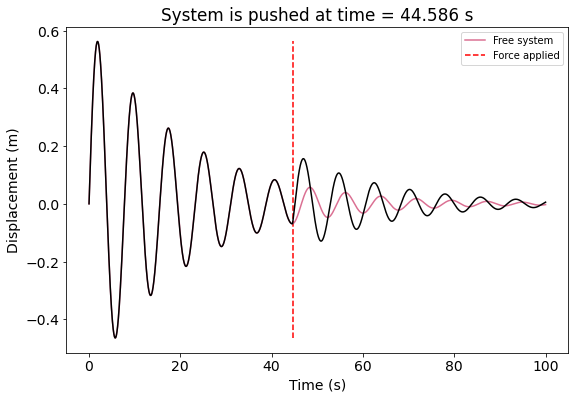

In [14]:
# Set initial conditions
x0 = 0
v0 = 0.5
F0 = 1 # N
b = 0.3

gamma = b / m
natural_frequency = np.sqrt(k / m)
frequency = np.sqrt(natural_frequency**2 - gamma**2 / 4)
period = 2 * np.pi / frequency # /s

push_times = (5 * period, 5.25 * period, 5.5 * period, 5.75 * period)

F0 = 100 # N
for push_time in push_times:
    force = delta_force(F0, push_time)
    time_range = np.linspace(0, total_time, int(total_time / h_step))
    displacement = forced_verlet_method(x0, v0, total_time, h_step, force)
    free_displacement = free_analytic_solution(x0, v0, total_time, h_step)[0]
    
    plt.plot(time_range, free_displacement, color='palevioletred', label='Free system')
    plt.plot(time_range, displacement, color='black')
    
    plt.vlines([push_time,], np.min(displacement) , np.max(displacement), color='red', linestyle='--', 
              label='Force applied')
    
    plt.title('System is pushed at time = {0:.3f} s'.format(push_time))
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    
    plt.legend(fontsize=10, loc='upper right')
    plt.show()




Pushing the system with a force creates a wave originating at the place where the source is. For a large force, this dominates the previous oscillations. 

As the push is starting another wave in the opposite direction, pushing the system at an equilibrium position in the opposite direction to the direction of motion should kill any oscillations as long as the force is of the correct magnitude. 

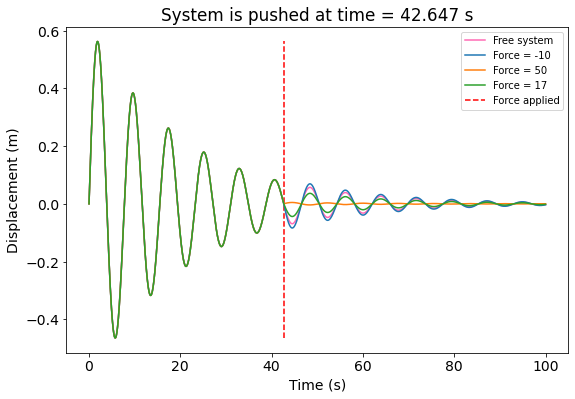

In [15]:
push_time = 5.5 * period

# Initial conditions
x0 = 0
v0 = 0.5

# Define constants
b = 0.3
F0s = (-10, 50, 17)

# Plot the free solution behind the pushed solutions
no_force = delta_force(0, push_time)
free_displacement = forced_verlet_method(x0, v0, total_time, h_step, no_force)
plt.plot(time_range, free_displacement, color='hotpink', label='Free system')

# Set the cycle of colours to make the plot nice
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["royalblue", "lightseagreen", "black"])

# Itterate through the forces
for F0 in F0s:
    force = delta_force(F0, push_time)
    
    time_range = np.linspace(0, total_time, int(total_time / h_step))
    displacement = forced_verlet_method(x0, v0, total_time, h_step, force)
    
    string = 'Force = {}'.format(F0)
    plt.plot(time_range, displacement, label=string)
    
    
    
    plt.title('System is pushed at time = {0:.3f} s'.format(push_time))
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    
# Plot a vertical line where the force is applied
plt.vlines([push_time,], np.min(displacement), np.max(displacement), color='red', linestyle='--', 
                label='Force applied')

plt.legend(fontsize=10, loc='upper right')
plt.show()


This plot shows that pushing the system at the correct time with the correct magnitude can kill the oscillations almost instantly. But, pushing with the wrong magnitude or in the wrong direction does not kill the oscillation.

### Periodic force

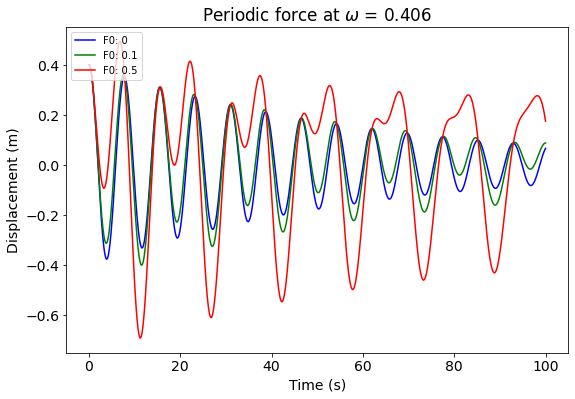

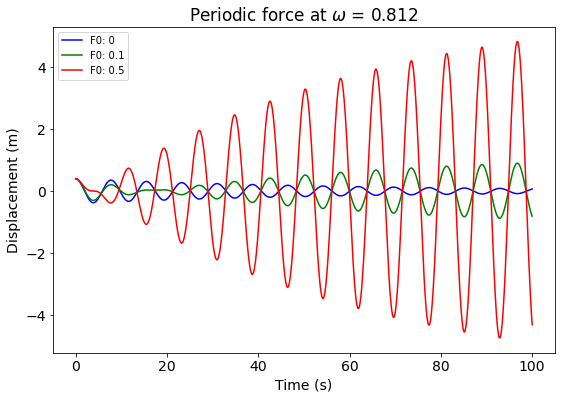

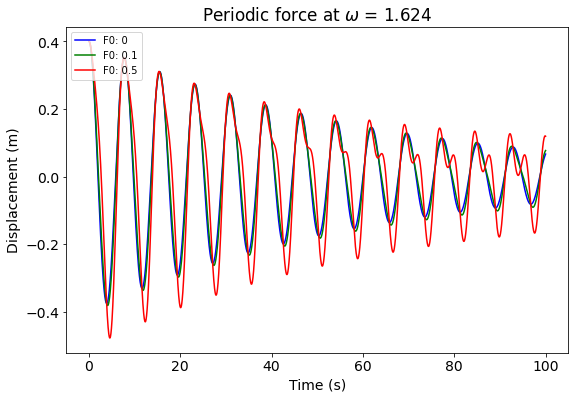

In [16]:
# Set plotting cycle 
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "red", "orange", "magenta"])

# Set initial conditions
x0 = 0.4
v0 = 0

# Set paramaters for the force
natural_frequency = np.sqrt(k / m)
total_time = 100
frequencies = (0.5 * natural_frequency, natural_frequency, 2 * natural_frequency)
phase = 0
force_size = (0, 0.1, 0.5) # N
b = 0.1

for frequency in frequencies:
    for F0 in force_size:
        force = periodic_force(frequency, total_time, h_step, phase, F0)
        x = forced_verlet_method(x0, v0, total_time, h_step, force)
        
        string = "F0: {}".format(F0)
        plt.plot(np.arange(0, total_time, h_step), x, label=string)
        plt.legend(fontsize=10, loc='upper left')
        
    plt.title(r"Periodic force at $\omega$ = {0:.3f}".format(frequency))
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.show()

The solution clearly shows a transient period where the system is changed by the application of the periodic force. Due to the damping, once the free system decays to zero (see the blue line) the system then oscillates regularly at the forced frequency with a constant amplitude. When the force is applied at the resonant frequency, the amplitude increases to infinity.


### Resonance

It can be seen from the plots above that forcing the system results in a different maximum amlitude. So the maximum amplitude was plotted against the driving frequency so produce a resonance curve. The range of frequencies investigated was the natural frequency $\pm 20 \% $ so that the natural frequency was centred on the plot.

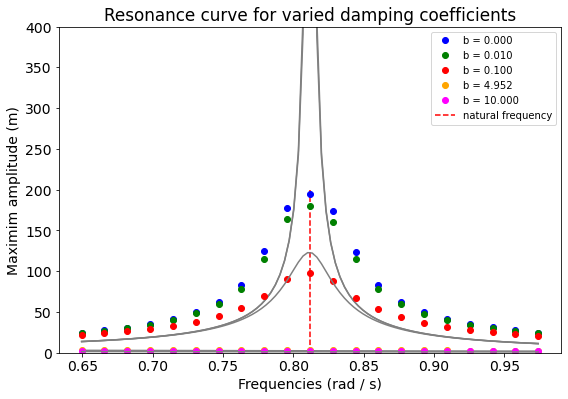

In [17]:
damping_range = (0, 0.01, 0.1, b_critical, 10)
h_step = 0.01
total_time = 100
phase = 0
F0 = 10


frequencies = np.linspace(0.8 * natural_frequency, 1.2 * natural_frequency, 21)

def resonance_curve():
    """
    """
    amplitudes = np.zeros(len(frequencies))
    
    for i, frequency in enumerate(frequencies):
        
        force = periodic_force(frequency, total_time, h_step, phase, F0)
        
        verlet_x = forced_verlet_method(x0, v0, total_time, h_step, force)
        peaks = find_peaks(verlet_x)[0]
        max_amp_index = np.argmax(verlet_x[peaks])
        max_amp = verlet_x[peaks[max_amp_index]]
        
        amplitudes[i] = max_amp
    
    return amplitudes
        
def plot_resonance_curve():
    """
    Plots the resonance curve.
    """
    amplitudes = resonance_curve()
    string = "b = {0:.3f}".format(b)
    
    
    plt.plot(frequencies, amplitudes, 'o', label=string)
    plt.title("Resonance curve for varied damping coefficients")
    plt.xlabel("Frequencies (rad / s)")
    plt.ylabel("Maximim amplitude (m)")

    gamma = b / m
    analytic_frequencies = np.linspace(0.8 * natural_frequency, 1.2 * natural_frequency, 100)
    sqrt_term = np.sqrt((natural_frequency**2 - analytic_frequencies**2)**2 + analytic_frequencies**2 * gamma**2)
    analytic_amplitude = F0 / (m * sqrt_term)

    plt.plot(analytic_frequencies, analytic_amplitude, color='grey')
    
for b in damping_range:
    plot_resonance_curve()
plt.ylim([0, 400])    
plt.vlines([natural_frequency,], 0, 200, color='red', linestyle='--', label='natural frequency')
plt.legend(fontsize=10)
plt.show()



It can be seen that, for smaller damping values, the numerical solution does not well describe the analytical solution as the frequency approaches the natural frequency. This is because the amplitude, theoretically, goes to infinity at the natural frequency. However, only a 100 s of time has been analysed so the system doesn't have sufficient time to go to large values. 

For large damping values where there is almost no oscillation the numerical solution does well represent the analytic solution as there are almost no oscillations.

To further investigate this the same plot will be plotted for a total time of 900 seconds to investigate how the numerical solution changes. Large damping terms will be omitted as they should remain the same as before. 

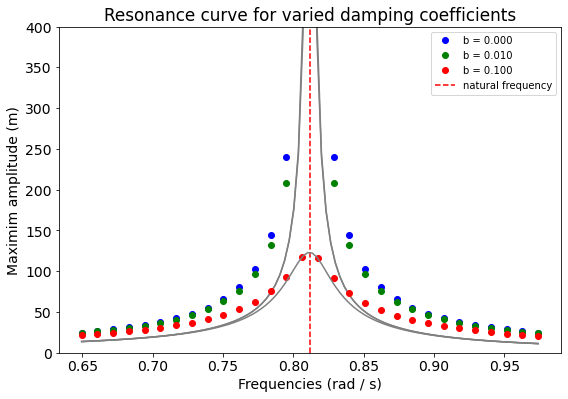

In [18]:
damping_range = (0, 0.01, 0.1)
h_step = 0.01
total_time = 900
phase = 0
F0 = 10

# Define a range of frequencies to investigate
frequencies = np.linspace(0.8 * natural_frequency, 1.2 * natural_frequency, 30)

# Itterate through damping values
for b in damping_range:
    plot_resonance_curve()
plt.ylim([0, 400])    
plt.vlines([natural_frequency,], 0, 400, color='red', linestyle='--', label='natural frequency')
plt.legend(fontsize=10)
plt.show()


The numerical solution has become a much better representation of the analytical solution. The analytical solution consideres the system at $time \rightarrow \infty$. So, this is not physically possible as even at the natural frequency a mass spring system can not oscilliate with an amplitude at infinity as the system will change or break preventing this.

### Phase

When a periodic force is applied to the system the system cannot respond instantly to the force, there must be a phase delay between the force and the displacement of the system.

Plot the force and the displacement on the same graph to investigate the phase difference.

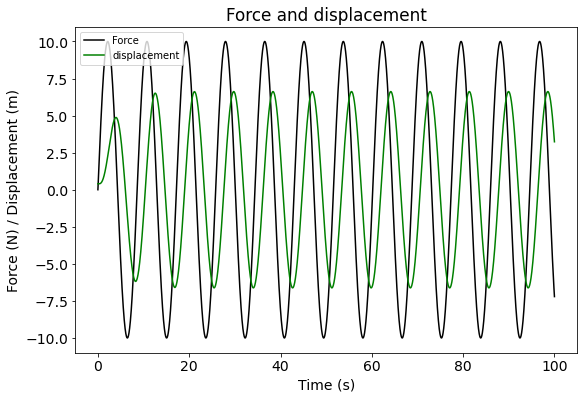

In [19]:
# Set parameters
total_time = 100 # s
F0 = 10 # N
b = 2
frequency = 0.9 * natural_frequency # rad / s

time_range = np.linspace(0, total_time, int(total_time / h_step))
force = periodic_force(frequency, total_time, h_step, phase, F0)
verlet_x = forced_verlet_method(x0, v0, total_time, h_step, force)

plt.plot(time_range, force, label='Force', color='black')
plt.plot(time_range, verlet_x, label='displacement', color='green')

plt.title('Force and displacement')
plt.xlabel('Time (s)')
plt.ylabel('Force (N) / Displacement (m)')
plt.legend(fontsize=10, loc='upper left')
plt.show()

It can be seen that there is a phase shift between the periodic force and the displacement of the mass. The phase lag between the force and the displacement follows $tan \delta = \frac{\omega_0 \gamma}{\omega_0^2 - \omega^2}$ where $\delta $ is the phase lag. The phase lag between as a function of the driving frequency was plotted.

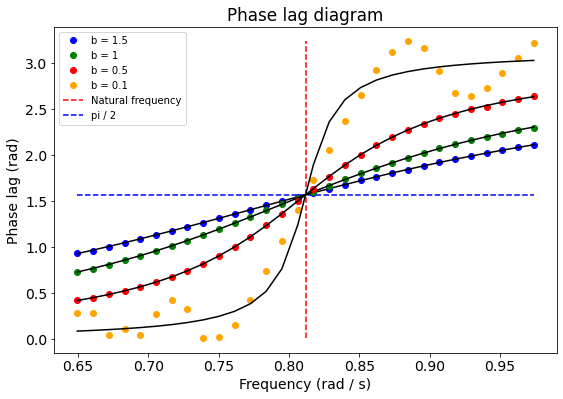

In [20]:
B = (1.5, 1, 0.5, 0.1,)
total_time = 100
natural_frequency = np.sqrt(k / m)

def find_phase(force, x):
    """
    Finds the phase difference.
    """
    
    force_peaks = find_peaks(force)[0]
    x_peaks = find_peaks(verlet_x)[0]
    
    time_difference = time_range[force_peaks[9]] - time_range[x_peaks[9]]
    
    phase = frequency * np.abs(time_difference)
    
    return phase

    
for b in B:
    # Define arrays to store values
    lag_phases = np.zeros(len(frequencies))
    ana_lag_phases = np.zeros(len(frequencies))
    
    # Determine gamma
    gamma = b / m
    
    # Itterate through the frequencies
    for i, frequency in enumerate(frequencies):
        
        # Call the Verlet method
        force = periodic_force(frequency, total_time, h_step, 0, F0)
        verlet_x = forced_verlet_method(x0, v0, total_time, h_step, force)
        lag_phase = find_phase(force, verlet_x)
        lag_phases[i] = lag_phase
        
        # Find the analytical solution
        term = frequency * gamma / (natural_frequency**2 - frequency**2)
    
        if frequency <= natural_frequency:
            ana_lag_phases[i] = np.arctan(term)
        else:
            ana_lag_phases[i] = np.arctan(term) + np.pi # arctan is [-pi/2, pi/2] so add pi to make it [0, pi]
            
    # Plot results
    verlet_label = 'b = {}'.format(b)
    plt.plot(frequencies, lag_phases, 'o', label=verlet_label)
    plt.plot(frequencies, ana_lag_phases, 'k')

plt.vlines([natural_frequency,], np.min(lag_phases), np.max(lag_phases), color='red', linestyle='--',
            label='Natural frequency')
plt.hlines([np.pi / 2,], np.min(frequencies), np.max(frequencies), color='blue', linestyle='--', label='pi / 2')
plt.title('Phase lag diagram')
plt.xlabel('Frequency (rad / s)')
plt.ylabel('Phase lag (rad)')
plt.legend(fontsize=10, loc='upper left')
plt.show()    
    

The plot shows that the numerical solution well represents the analytical solution. For small damping coefficients, the numerical solution does not follow the analytical solution but appears to oscillate around the tails of the graph and has a shallower slope.

# Summary

The best method was chosen by finding the most accurate method for the most damping cases. The Verlet method was determined to be the best method as it was the most accurate in all cases except for damping values much smaller than the critical value where the Euler-Cromer was found to be the best method. The accuracy was determined by comparing the numerical method to the analytical solution, and investigatong the residuals, the average error per step and the energy evolution of the system. The step size was then investidated by considering the error in the second to last peak and the average error per step, it was decided that the best step size would have both measurements below a specified tolerance. The best step size was found to be 0.004 s. 

Once the best method and step size had been determined, the numerical method was used to investigate the system with an external force which does not have a simple analytic solution. It was found that pushing the system at the equilibrium position can kill the oscillations quickly. 

It was shown that the frequency of an applied force affects the amplitude at which it oscillates. So a resonance curve was plotted showing that the amplitude greatly increases as you approach the natural frequency. However, the resonance curve was not as steep as the analytical solution. This was because the analytical solution is at a time $t \rightarrow \infty$. Increasing the total time investigated made the numerical solution match the analytical much better. Physically, the analytical solution is impossible as a spring cannot oscillate with an amplitude of infinity. 

Lastly, the phase difference between the applied force and the displacement responce was investigated. The numerical solution followed the expected arctan shape but for smaller damping coefficients the solution is much less accurate.